In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import os

## Data Loading

In [2]:
train_dir = '/kaggle/input/cifar10/cifar10/train'
test_dir = '/kaggle/input/cifar10/cifar10/test'

batch_size = 32
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),                   
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # Normalize with ImageNet stats
                         std=[0.229, 0.224, 0.225])
])


In [3]:
train_dataset_full = datasets.ImageFolder(
    root=train_dir,
    transform=data_transforms
)

test_dataset = datasets.ImageFolder(
    root=test_dir,
    transform=data_transforms
)


total_train_size = len(train_dataset_full)
val_size = int(total_train_size * 0.2)
train_size = total_train_size - val_size

train_dataset, val_dataset = random_split(train_dataset_full, [train_size, val_size])

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,  
    num_workers=4  
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    shuffle=False, 
    num_workers=4
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False, 
    num_workers=4
)


In [4]:
print(train_dataset_full.class_to_idx)         # class index

{'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Pretrained Swin Transformer
### fine tuning and extracting the semantic rich embeddings from the pretrained swin transformer

In [6]:
from transformers import AutoModelForImageClassification
from PIL import Image

model = AutoModelForImageClassification.from_pretrained("microsoft/swin-tiny-patch4-window7-224")

num_classes = 10
in_features = model.classifier.in_features
model.classifier = nn.Linear(in_features, num_classes)
model.to(device)

config.json: 0.00B [00:00, ?B/s]

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

model.safetensors:   0%|          | 0.00/113M [00:00<?, ?B/s]

SwinForImageClassification(
  (swin): SwinModel(
    (embeddings): SwinEmbeddings(
      (patch_embeddings): SwinPatchEmbeddings(
        (projection): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      )
      (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): SwinEncoder(
      (layers): ModuleList(
        (0): SwinStage(
          (blocks): ModuleList(
            (0): SwinLayer(
              (layernorm_before): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
              (attention): SwinAttention(
                (self): SwinSelfAttention(
                  (query): Linear(in_features=96, out_features=96, bias=True)
                  (key): Linear(in_features=96, out_features=96, bias=True)
                  (value): Linear(in_features=96, out_features=96, bias=True)
                  (dropout): Dropout(p=0.0, inplace=False)
                )
                (output): SwinSelfOutput(
        

### Fine tuning

In [7]:
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss
from tqdm import tqdm

optimizer = AdamW(model.parameters(), lr = 1e-5)
criterion = CrossEntropyLoss()
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad()
        outputs = model(images) 
        logits = outputs.logits
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    print(f"Epoch {epoch+1}\n – Train Avg loss: {train_loss/len(train_loader):.4f}")
    model.eval()
    correct = 0
    total = 0
    eval_loss= 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader):
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            
            outputs = model(images)
            logits = outputs.logits
            
            loss = criterion(logits, labels)
            eval_loss += loss.item()
            
            _, predicted = torch.max(logits, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    print(f"Val Accuracy: {100 * correct / total:.2f}%\n Val Avg loss: {eval_loss/len(val_loader):.4f} \n")        

Epoch 1/5: 100%|██████████| 1250/1250 [08:53<00:00,  2.34it/s]


Epoch 1
 – Train Avg loss: 0.3088


100%|██████████| 313/313 [00:50<00:00,  6.21it/s]


Val Accuracy: 95.62%
 Val Avg loss: 0.1277 



Epoch 2/5: 100%|██████████| 1250/1250 [08:59<00:00,  2.32it/s]


Epoch 2
 – Train Avg loss: 0.0831


100%|██████████| 313/313 [00:50<00:00,  6.21it/s]


Val Accuracy: 97.10%
 Val Avg loss: 0.0934 



Epoch 3/5: 100%|██████████| 1250/1250 [08:59<00:00,  2.32it/s]


Epoch 3
 – Train Avg loss: 0.0426


100%|██████████| 313/313 [00:50<00:00,  6.23it/s]


Val Accuracy: 97.05%
 Val Avg loss: 0.0936 



Epoch 4/5: 100%|██████████| 1250/1250 [08:59<00:00,  2.32it/s]


Epoch 4
 – Train Avg loss: 0.0259


100%|██████████| 313/313 [00:50<00:00,  6.23it/s]


Val Accuracy: 97.51%
 Val Avg loss: 0.0859 



Epoch 5/5: 100%|██████████| 1250/1250 [08:59<00:00,  2.32it/s]


Epoch 5
 – Train Avg loss: 0.0157


100%|██████████| 313/313 [00:50<00:00,  6.22it/s]

Val Accuracy: 97.26%
 Val Avg loss: 0.0956 



In [23]:
torch.save(model.state_dict(), "model.pt")

### Evaluation on test dataset

In [28]:
model_path = "/kaggle/working/model.pt"
model = AutoModelForImageClassification.from_pretrained("microsoft/swin-tiny-patch4-window7-224")

num_classes = 10
in_features = model.classifier.in_features
model.classifier = nn.Linear(in_features, num_classes)

state_dict = torch.load("/kaggle/working/model.pt")
model.load_state_dict(state_dict)
model.to(device)
model.eval()

all_embeddings = []
all_labels = []

correct = 0
total = 0

with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        logits = outputs.logits
        _, predicted = torch.max(logits, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        features = model.swin(images)
        cls_embedding = features.pooler_output

        all_embeddings.append(cls_embedding.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

print(f"Test Accuracy: {100 * correct / total:.2f}%")
all_embeddings = np.concatenate(all_embeddings, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

100%|██████████| 313/313 [01:37<00:00,  3.22it/s]

Test Accuracy: 97.28%


### Extracting the Embeddings

In [30]:
num_classes = len(test_dataset.class_to_idx)
class_embeddings = np.zeros((num_classes, all_embeddings.shape[1]))
for i in range(num_classes):
    class_mask = (all_labels == i)
    class_embeddings[i] = all_embeddings[class_mask].mean(axis = 0)

### Pair wise semantic similarity score using cosine similarity 

In [31]:
from sklearn.metrics.pairwise import cosine_similarity

class_names = test_dataset.class_to_idx.keys()

similarity_matrix = cosine_similarity(class_embeddings)
np.fill_diagonal(similarity_matrix, 0)  # As the diagonal elements will obviously be 1 but set to 0 to give importance to non identical classes(cross class similarity)

df = pd.DataFrame(similarity_matrix, index=class_names, columns=class_names)


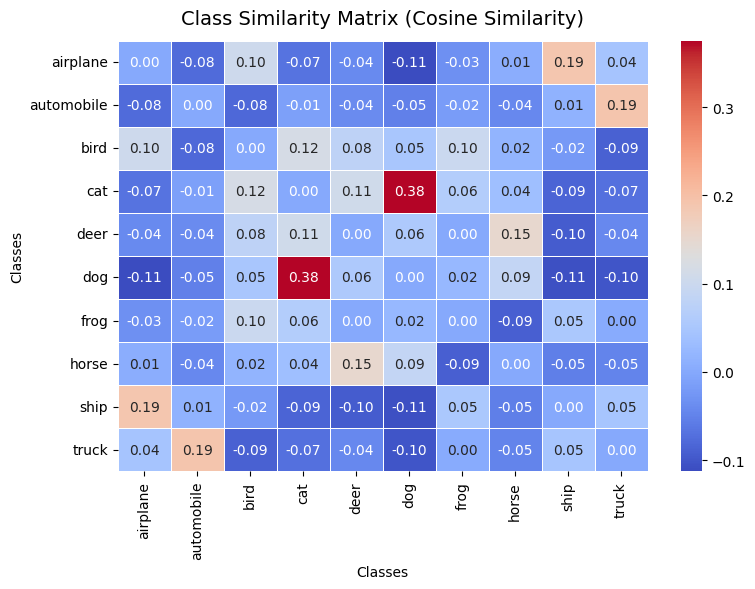

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(df, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Class Similarity Matrix (Cosine Similarity)", fontsize=14, pad=12)
plt.xlabel("Classes")
plt.ylabel("Classes")
plt.tight_layout()
plt.show()

#### for example, we can see that cat and dog are highly similar compared to other cross class similarity.
#### another example is automobile and truck